In [1]:
!conda update -c conda-forge jupyterlab -y
!conda install ipywidgets -y
!pip install u8darts

Solving environment: | 

Updating jupyterlab is constricted by 

anaconda -> requires jupyterlab==1.2.6=pyhf63ae98_0

If you are sure you want an update of your package either try `conda update --all` or install a specific version of the package you want using `conda install <pkg>=<version>`

done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/stephaniechew/opt/anaconda3

  added / updated specs:
    - jupyterlab


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    applaunchservices-0.2.1    |             py_0           8 KB  conda-forge
    appnope-0.1.0              |           py37_0           8 KB  conda-forge
    asn1crypto-1.3.0           |           py37_0         159 KB  conda-forge
    attrs-19.3.0 

In [111]:
%matplotlib inline

import sys
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    #Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    StandardRegressionModel,
    Theta,
    FFT
)
from darts.metrics import mape, mase
from darts.backtesting import (
    backtest_forecasting,
    backtest_regression,
    plot_residuals_analysis,
    forecasting_residuals
)
from darts.utils.statistics import check_seasonality, plot_acf

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import ipywidgets as widgets
import statsmodels.formula.api as smf
import seaborn as sns

In [80]:

df = pd.read_csv('Datasets/CDs_all_2018to2020.csv')
df.info()
df['Quarter_Date'] = pd.to_datetime(df['Quarter_Date'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125548 entries, 0 to 125547
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    125548 non-null  int64  
 1   cert          125548 non-null  int64  
 2   name          125548 non-null  object 
 3   city          125548 non-null  object 
 4   state         125548 non-null  object 
 5   zip           125548 non-null  int64  
 6   cb            125548 non-null  int64  
 7   inst.webaddr  108391 non-null  object 
 8   NTRCDSM       82102 non-null   float64
 9   NTRTMMED      82102 non-null   float64
 10  Quarter_Date  125548 non-null  object 
 11  IDcd3less     125350 non-null  float64
 12  IDcd3t12s     125350 non-null  float64
 13  IDcd1t3s      125350 non-null  float64
 14  IDcdov3s      125350 non-null  float64
 15  NTRTMLGJ      82102 non-null   float64
 16  ntrcdsm       43248 non-null   float64
dtypes: float64(8), int64(4), object(5)
memory usage:

In [81]:
df2 = df[['Quarter_Date', 'IDcd3less']]

df2_grouped = df2.groupby('Quarter_Date')['IDcd3less'].sum()

df2_grouped = df2_grouped.reset_index()

df2_grouped['Quarter'] = df2_grouped['Quarter_Date']


df2_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Quarter_Date  22 non-null     datetime64[ns]
 1   IDcd3less     22 non-null     float64       
 2   Quarter       22 non-null     datetime64[ns]
dtypes: datetime64[ns](2), float64(1)
memory usage: 656.0 bytes


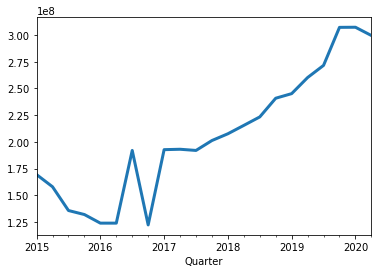

In [154]:

series = TimeSeries.from_dataframe(df2_grouped, 'Quarter','IDcd3less')
series.plot(lw=3)
model_es = StandardRegressionModel(19)




In [151]:
StandardRegressionModel??

Init signature:
StandardRegressionModel(
    train_n_points: int,
    model=LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=False),
)
Docstring:     
Helper class that provides a standard way to create an ABC using
inheritance.
Source:        
class StandardRegressionModel(RegressionModel):

    def __init__(self,
                 train_n_points: int,
                 model=LinearRegression(n_jobs=-1, fit_intercept=False)):
        """
        Simple wrapper for regression models implementing a fit() predict() functions models
        (e.g., scikit-learn regression).

        Parameters
        ----------
        train_n_points
            The number of most recent points from the training (features and target) time series that
            will be used to train the regression model. If this is `None`, or if the provided training series
            contain fewer points, the maximum possible number of time steps will be used for training.
        model
           

In [155]:
historical_fcast_es = backtest_forecasting(series, model_es, pd.Timestamp('2019-12-31'), fcast_horizon_n=3, verbose=True)
series.plot(label='data')
historical_fcast_es.plot(lw=3, label='backtest 3-months ahead forecast (Exp. Smoothing)')
plt.title('MAPE = {:.3f}%'.format(mape(historical_fcast_es, series)))
plt.legend()

TypeError: fit() missing 1 required positional argument: 'train_target'

In [88]:
backtest_forecasting??

Signature:
backtest_forecasting(
    series: darts.timeseries.TimeSeries,
    model: darts.models.forecasting_model.ForecastingModel,
    start: pandas._libs.tslibs.timestamps.Timestamp,
    fcast_horizon_n: int,
    trim_to_series: bool = True,
    verbose: bool = False,
) -> darts.timeseries.TimeSeries
Source:   
def backtest_forecasting(series: TimeSeries,
                         model: ForecastingModel,
                         start: pd.Timestamp,
                         fcast_horizon_n: int,
                         trim_to_series: bool = True,
                         verbose: bool = False) -> TimeSeries:
    """ A function for backtesting `ForecastingModel`'s.

    This function computes the time series of historical predictions
    that would have been obtained, if `model` had been used to predict `series`
    with a certain time horizon.

    To this end, it repeatedly builds a training set from the beginning of `series`.
    It trains `model` on the training set, emits a (

In [64]:
TimeSeries.from_dataframe??

Signature:
TimeSeries.from_dataframe(
    df: pandas.core.frame.DataFrame,
    time_col: Union[str, NoneType],
    value_cols: Union[List[str], str],
    freq: Union[str, NoneType] = None,
    fill_missing_dates: Union[bool, NoneType] = True,
) -> 'TimeSeries'
Source:   
    @staticmethod
    def from_dataframe(df: pd.DataFrame,
                       time_col: Optional[str],
                       value_cols: Union[List[str], str],
                       freq: Optional[str] = None,
                       fill_missing_dates: Optional[bool] = True) -> 'TimeSeries':
        """
        Returns a TimeSeries instance built from a selection of columns of a DataFrame.
        One column (or the DataFrame index) has to represent the time,
        and a list of columns `value_cols` has to represent the values for this time series.

        Parameters
        ----------
        df
            The DataFrame
        time_col
            The time column name (mandatory). If set to `None`, the Data

In [71]:
df2['Quarter_Date'].value_counts()

2015-03-30    6428
2015-06-30    6357
2015-09-30    6279
2015-12-30    6191
2016-03-30    6067
2016-06-30    6067
2016-12-30    5922
2017-03-30    5865
2017-06-30    5796
2017-09-30    5747
2016-09-30    5747
2017-12-30    5679
2018-03-30    5615
2018-06-30    5551
2018-09-30    5486
2018-12-30    5415
2019-03-30    5371
2019-06-30    5312
2019-09-30    5267
2019-12-30    5186
2020-03-30    5125
2020-06-30    5075
Name: Quarter_Date, dtype: int64

In [56]:
df2.head(100)

,Quarter_Date,IDcd3less
0,2020-06-30,6391.0
1,2020-06-30,8362.0
2,2020-06-30,1433.0
3,2020-06-30,3678.0
4,2020-06-30,5826.0
...,...,...
95,2020-06-30,46682.0
96,2020-06-30,3818.0
97,2020-06-30,3030.0
98,2020-06-30,22046.0


In [187]:
from sklearn.model_selection import train_test_split


formula = 'IDcd3t12s ~ C(Quarter_Date) + IDcd1t3s'
lm = smf.ols(formula=formula, data=train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              IDcd3t12s   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                 1.207e+04
Date:                Mon, 05 Oct 2020   Prob (F-statistic):               0.00
Time:                        10:49:30   Log-Likelihood:            -1.3246e+06
No. Observations:               94018   AIC:                         2.649e+06
Df Residuals:                   93995   BIC:                         2.649e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                            5174.9239   4601.503      1.125      0.261   -3843.972    1.42e+04
C(Quarter_Date)[T.Timestamp('2015-06-30 00:00:00')]    27.6241   6527.333      0.004      0.997   -1.28e+04    1.28e+04
C(Quarter_Date)[T.Timestamp('2015-09-30 00:00:00')] -2953.3556   6517.291     -0.453      0.650   -1.57e+04    9820.465
C(Quarter_Date)[T.Timestamp('2015-12-31 00:00:00')]  -332.3830   6553.101     -0.051      0.960   -1.32e+04    1.25e+04
C(Quarter_Date)[T.Timestamp('2016-03-31 00:00:00')] -4519.2486   6603.439     -0.684      0.494   -1.75e+04    8423.420
C(Quarter_Date)[T.Timestamp('2016-06-30 00:00:00')] -2467.7905   6602.674     -0.374      0.709   -1.54e+04    1.05e+04
C(Quarter_Date)[T.Timestamp('2016-09-30 00:00:00')] -1101.6746   6676.162     -0.165      0.869   -1.42e+04     1.2e+04
C(Quarter_Date)[T.Timestamp('2016-12-31 00:00:00')] -4246.6855   6616.333     -0.642      0.521   -1.72e+04    8721.256
C(Quarter_Date)[T.Timestamp('2017-03-31 00:00:00')]  -577.4423   6647.627     -0.087      0.931   -1.36e+04    1.25e+04
C(Quarter_Date)[T.Timestamp('2017-06-30 00:00:00')] -2446.0005   6658.750     -0.367      0.713   -1.55e+04    1.06e+04
C(Quarter_Date)[T.Timestamp('2017-09-30 00:00:00')]  5348.7748   6685.752      0.800      0.424   -7755.227    1.85e+04
C(Quarter_Date)[T.Timestamp('2017-12-31 00:00:00')]  5675.3776   6697.432      0.847      0.397   -7451.516    1.88e+04
C(Quarter_Date)[T.Timestamp('2018-03-31 00:00:00')]  3688.8183   6728.963      0.548      0.584   -9499.877    1.69e+04
C(Quarter_Date)[T.Timestamp('2018-06-30 00:00:00')]  3926.7949   6732.830      0.583      0.560   -9269.479    1.71e+04
C(Quarter_Date)[T.Timestamp('2018-09-30 00:00:00')]  4985.6406   6747.709      0.739      0.460   -8239.796    1.82e+04
C(Quarter_Date)[T.Timestamp('2018-12-31 00:00:00')]  3154.7189   6804.268      0.464      0.643   -1.02e+04    1.65e+04
C(Quarter_Date)[T.Timestamp('2019-03-31 00:00:00')]  1.871e+04   6798.166      2.752      0.006    5387.255     3.2e+04
C(Quarter_Date)[T.Timestamp('2019-06-30 00:00:00')]  3.194e+04   6809.389      4.690      0.000    1.86e+04    4.53e+04
C(Quarter_Date)[T.Timestamp('2019-09-30 00:00:00')]  4.073e+04   6844.249      5.950      0.000    2.73e+04    5.41e+04
C(Quarter_Date)[T.Timestamp('2019-12-31 00:00:00')]  3.796e+04   6896.637      5.505      0.000    2.44e+04    5.15e+04
C(Quarter_Date)[T.Timestamp('2020-03-31 00:00:00')]  4.448e+04   6886.728      6.459      0.000     3.1e+04     5.8e+04
C(Quarter_Date)[T.Timestamp('2020-06-30 00:00:00')]  3.587e+04   6920.648      5.183      0.000    2.23e+04    4.94e+04
IDcd1t3s                                                1.2267      0.002    514.46

In [179]:
#Community banks vs Large banks
df_x = df[['state', 'Quarter_Date', 'cb']]
df_y = df[['IDcd3t12s']]

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y,test_size = 0.2)

cd_train = pd.concat([X_train, y_train], axis = 1)
cd_train

# lm = smf.ols(formula='IDcd3t12s ~ city + state', data=train).fit()
# lm.summary()

,state,Quarter_Date,cb,IDcd3t12s
78694,LA,2016-12-31,1,109721.0
6200,KS,2020-03-31,1,36805.0
25480,OK,2019-06-30,1,13708.0
103905,CA,2015-12-31,1,16047.0
115126,IA,2015-06-30,1,21006.0
...,...,...,...,...
106399,MT,2015-12-31,1,2190.0
20813,PA,2019-06-30,1,52624.0
65370,LA,2017-06-30,1,15578.0
63040,WA,2017-09-30,1,55277.0


In [180]:
cd_test = pd.concat([X_test,y_test], axis = 1)
cd_test

,state,Quarter_Date,cb,IDcd3t12s
76952,MO,2016-12-31,1,3919.0
40189,VT,2018-09-30,1,31077.0
115899,TX,2015-06-30,1,4684.0
101797,MI,2015-12-31,1,11678.0
122204,NC,2015-03-31,0,128426.0
...,...,...,...,...
118362,MS,2015-06-30,1,8617.0
84534,PA,2016-09-30,0,1102354.0
97965,LA,2016-03-31,0,72912.0
20650,TX,2019-09-30,1,15232.0


In [182]:
linear_model = smf.ols(formula='IDcd3t12s ~ C(Quarter_Date) + C(cb)', data=cd_train).fit()

linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              IDcd3t12s   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     382.6
Date:                Mon, 28 Sep 2020   Prob (F-statistic):               0.00
Time:                        19:34:22   Log-Likelihood:            -1.4752e+06
No. Observations:              100285   AIC:                         2.950e+06
Df Residuals:                  100262   BIC:                         2.951e+06
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                            6.272e+05   1.05e+04     59.794      0.000    6.07e+05    6.48e+05
C(Quarter_Date)[T.Timestamp('2015-06-30 00:00:00')]   300.5667   1.17e+04      0.026      0.980   -2.27e+04    2.33e+04
C(Quarter_Date)[T.Timestamp('2015-09-30 00:00:00')]   118.5821   1.17e+04      0.010      0.992   -2.29e+04    2.31e+04
C(Quarter_Date)[T.Timestamp('2015-12-31 00:00:00')]  1435.3488   1.18e+04      0.122      0.903   -2.17e+04    2.45e+04
C(Quarter_Date)[T.Timestamp('2016-03-31 00:00:00')] -3803.7842   1.18e+04     -0.321      0.748    -2.7e+04    1.94e+04
C(Quarter_Date)[T.Timestamp('2016-06-30 00:00:00')] -3585.9294   1.19e+04     -0.302      0.763   -2.69e+04    1.97e+04
C(Quarter_Date)[T.Timestamp('2016-09-30 00:00:00')]   2.81e+04    1.2e+04      2.338      0.019    4539.884    5.17e+04
C(Quarter_Date)[T.Timestamp('2016-12-31 00:00:00')] -1612.9495   1.19e+04     -0.135      0.892    -2.5e+04    2.18e+04
C(Quarter_Date)[T.Timestamp('2017-03-31 00:00:00')]  2.303e+04   1.19e+04      1.930      0.054    -359.864    4.64e+04
C(Quarter_Date)[T.Timestamp('2017-06-30 00:00:00')]  1.908e+04    1.2e+04      1.587      0.113   -4485.510    4.26e+04
C(Quarter_Date)[T.Timestamp('2017-09-30 00:00:00')]  3.106e+04   1.21e+04      2.574      0.010    7410.823    5.47e+04
C(Quarter_Date)[T.Timestamp('2017-12-31 00:00:00')]  3.336e+04   1.21e+04      2.763      0.006    9699.523     5.7e+04
C(Quarter_Date)[T.Timestamp('2018-03-31 00:00:00')]  3.458e+04   1.21e+04      2.862      0.004    1.09e+04    5.83e+04
C(Quarter_Date)[T.Timestamp('2018-06-30 00:00:00')]   3.23e+04   1.21e+04      2.660      0.008    8503.046    5.61e+04
C(Quarter_Date)[T.Timestamp('2018-09-30 00:00:00')]  5.182e+04   1.22e+04      4.244      0.000    2.79e+04    7.58e+04
C(Quarter_Date)[T.Timestamp('2018-12-31 00:00:00')]   5.28e+04   1.22e+04      4.329      0.000    2.89e+04    7.67e+04
C(Quarter_Date)[T.Timestamp('2019-03-31 00:00:00')]  6.212e+04   1.23e+04      5.069      0.000    3.81e+04    8.61e+04
C(Quarter_Date)[T.Timestamp('2019-06-30 00:00:00')]  6.834e+04   1.23e+04      5.558      0.000    4.42e+04    9.24e+04
C(Quarter_Date)[T.Timestamp('2019-09-30 00:00:00')]  6.575e+04   1.23e+04      5.342      0.000    4.16e+04    8.99e+04
C(Quarter_Date)[T.Timestamp('2019-12-31 00:00:00')]   8.09e+04   1.24e+04      6.522      0.000    5.66e+04    1.05e+05
C(Quarter_Date)[T.Timestamp('2020-03-31 00:00:00')]  7.565e+04   1.24e+04      6.094      0.000    5.13e+04       1e+05
C(Quarter_Date)[T.Timestamp('2020-06-30 00:00:00')]  6.842e+04   1.24e+04      5.504      0.000    4.41e+04    9.28e+04
C(cb)[T.1]                                           -6.31e+05   6988.885    -90.28

In [184]:
y_test_pred = linear_model.predict(X_test)
y_test_pred

76952      -5383.897374
40189      48049.677625
115899     -3470.381115
101797     -2335.599007
122204    627193.549454
              ...      
118362     -3470.381115
84534     655289.316580
97965     623389.765293
20650      61982.154360
4698       64651.981311
Length: 25110, dtype: float64

TypeError: unsupported operand type(s) for *: 'Timestamp' and 'float'

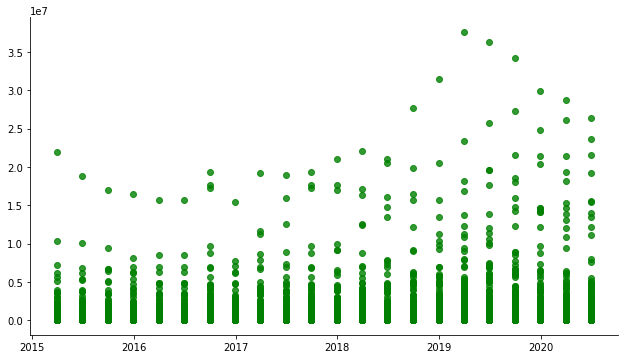

In [186]:
#NTRTMLGJ = Time deposits over insurance limit
#banks ~ states, city, zip, community banks vs large bank

sns.lmplot(x = "Quarter_Date", y = "IDcd3t12s", 
                data = df, height = 5, aspect = 16/9,hue='cb', palette = ['green', 'blue'], ci = False)